In [0]:
import scipy
from scipy import io

import matplotlib.pyplot as plt
import numpy as np

from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBRegressor
import pandas as pd
#Load Data
import os
import glob
import csv

In [0]:
Year_2013 = ['2013-03-01','2013-04-01','2013-05-01','2013-06-01','2013-07-01','2013-08-01','2013-09-01','2013-10-01','2013-11-01','2013-12-01']
Year_2014 = ['2014-01-01','2014-02-01','2014-03-01','2014-04-01','2014-05-01','2014-06-01','2014-07-01'
              ,'2014-08-01','2014-09-01','2014-10-01','2014-11-01','2014-12-01']
Year_2015 = ['2015-01-01','2015-02-01','2015-03-01','2015-04-01','2015-05-01','2015-06-01','2015-07-01'
              ,'2015-08-01','2015-09-01','2015-10-01','2015-11-01','2015-12-01']
Year_2016 = ['2016-01-01','2016-02-01','2016-03-01','2016-04-01','2016-05-01','2016-06-01','2016-07-01'
              ,'2016-08-01','2016-09-01','2016-10-01','2016-11-01','2016-12-01']
Year_2017 = ['2017-01-01','2017-02-01','2017-03-01','2017-04-01','2017-05-01','2017-06-01','2017-07-01'
              ,'2017-08-01','2017-09-01','2017-10-01','2017-11-01','2017-12-01']
Year_2018 = ['2018-01-01','2018-02-01','2018-03-01','2018-04-01','2018-05-01','2018-06-01','2018-07-01'
              ,'2018-08-01','2018-09-01','2018-10-01','2018-11-01','2018-12-01']
Year_2019 = ['2019-01-01','2019-02-01','2019-03-01','2019-04-01','2019-05-01','2019-06-01','2019-07-01'
              ,'2019-08-01','2019-09-01','2019-10-01','2019-11-01','2019-12-01']
Year_2020 = ['2020-01-01']

In [0]:
def Set_Holiday(hdate, year_frame):
  startdate = pd.to_datetime(hdate).date()
  year_frame.loc[year_frame['Date'] == startdate,['Holiday']] =1


In [0]:
#for 2019
sp500_table = {}
for i in range (12):
    file_name = 'https://www.nratrafficdata.ie/c2/tfmonthreport.asp?sgid=ZvyVmXU8jBt9PJE$c7UXt6&spid=NRA_000000001013&reportdate=' + Year_2019[i] + '&dim1bin=-1&precision=2'
    url = file_name
    tables = pd.read_html(url, header=[1], index_col=0) # Returns list of all tables on page
    sp500_table[i] = tables[0] # Select table of interest
    cols = sp500_table[i].columns.difference(['Workday','7 Day','Count'], sort=False)
    sp500_table[i] = sp500_table[i].loc[sp500_table[i].index.str.contains('^\d{2}:\d{2}$', na=False), cols]
    sp500_table[i].columns = pd.to_datetime(sp500_table[i].columns + ' 2019', format='%d %b %Y')
    sp500_table[i].index = pd.to_timedelta(sp500_table[i].index + ':00')

    sp500_table[i] = sp500_table[i].reset_index().melt('index')
    sp500_table[i].index = pd.to_datetime(sp500_table[i].pop('variable')) + pd.to_timedelta(sp500_table[i].pop('index'))
    
    #Renaming column name
    sp500_table[i].columns.values[0]='Volume_of_Traffic'

    sp500_table[i]['Day'] = sp500_table[i].index.day_name()
    sp500_table[i]['Date'] = sp500_table[i].index.date

    sp500_table[i]['Year'] = sp500_table[i].index.year
    sp500_table[i]['MonthSlot'] = sp500_table[i].index.month
    sp500_table[i]['DaySlot'] = sp500_table[i].index.day

    sp500_table[i]['HourSlot'] = sp500_table[i].index.time
    sp500_table[i]['WEEKDAY'] = pd.to_datetime(sp500_table[i]['Date']).dt.dayofweek

    sp500_table[i]['Holiday'] = 0


    List_of_Hours = sp500_table[i]['HourSlot'].unique()
    Hours_Dict = dict(zip(List_of_Hours, range(len(List_of_Hours))))
    sp500_table[i] = sp500_table[i].applymap(lambda s: Hours_Dict.get(s) if s in Hours_Dict else s)

    sp500_table[i]['hr_sin'] = np.sin(sp500_table[i]['HourSlot']*(2.*np.pi/24))
    sp500_table[i]['hr_cos'] = np.cos(sp500_table[i].HourSlot*(2.*np.pi/24))

    #We change the mapping of the month from 1-12 to 0-11 
    sp500_table[i]['month_sin'] = np.sin((sp500_table[i].MonthSlot-1)*(2.*np.pi/12))
    sp500_table[i]['month_cos'] = np.cos((sp500_table[i].MonthSlot-1)*(2.*np.pi/12))

    #No change is required in mapping as weekday itself is in 0-6
    sp500_table[i]['weekday_sin'] = np.sin((sp500_table[i].WEEKDAY)*(2.*np.pi/7))
    sp500_table[i]['weekday_cos'] = np.cos((sp500_table[i].WEEKDAY)*(2.*np.pi/7))

    #We change the mapping of the month from 1-31 to 0-30 
    Size_of_Month = pd.unique(sp500_table[i].DaySlot).size
    sp500_table[i]['DaySlot_sin'] = np.sin((sp500_table[i].DaySlot-1)*(2.*np.pi/Size_of_Month))
    sp500_table[i]['DaySlot_cos'] = np.cos((sp500_table[i].DaySlot-1)*(2.*np.pi/Size_of_Month))

Data_2019 = pd.concat(sp500_table,ignore_index=True)


In [0]:
#for 2018
sp500_table = {}
for i in range (12):
    file_name = 'https://www.nratrafficdata.ie/c2/tfmonthreport.asp?sgid=ZvyVmXU8jBt9PJE$c7UXt6&spid=NRA_000000001013&reportdate=' + Year_2018[i] + '&dim1bin=-1&precision=2'
    url = file_name
    tables = pd.read_html(url, header=[1], index_col=0) # Returns list of all tables on page
    sp500_table[i] = tables[0] # Select table of interest
    cols = sp500_table[i].columns.difference(['Workday','7 Day','Count'], sort=False)
    sp500_table[i] = sp500_table[i].loc[sp500_table[i].index.str.contains('^\d{2}:\d{2}$', na=False), cols]
    sp500_table[i].columns = pd.to_datetime(sp500_table[i].columns + ' 2018', format='%d %b %Y')
    sp500_table[i].index = pd.to_timedelta(sp500_table[i].index + ':00')

    sp500_table[i] = sp500_table[i].reset_index().melt('index')
    sp500_table[i].index = pd.to_datetime(sp500_table[i].pop('variable')) + pd.to_timedelta(sp500_table[i].pop('index'))
    
    #Renaming column name
    sp500_table[i].columns.values[0]='Volume_of_Traffic'

    sp500_table[i]['Day'] = sp500_table[i].index.day_name()
    sp500_table[i]['Date'] = sp500_table[i].index.date

    sp500_table[i]['Year'] = sp500_table[i].index.year
    sp500_table[i]['MonthSlot'] = sp500_table[i].index.month
    sp500_table[i]['DaySlot'] = sp500_table[i].index.day

    sp500_table[i]['HourSlot'] = sp500_table[i].index.time
    sp500_table[i]['WEEKDAY'] = pd.to_datetime(sp500_table[i]['Date']).dt.dayofweek

    sp500_table[i]['Holiday'] = 0


    List_of_Hours = sp500_table[i]['HourSlot'].unique()
    Hours_Dict = dict(zip(List_of_Hours, range(len(List_of_Hours))))
    sp500_table[i] = sp500_table[i].applymap(lambda s: Hours_Dict.get(s) if s in Hours_Dict else s)

    sp500_table[i]['hr_sin'] = np.sin(sp500_table[i]['HourSlot']*(2.*np.pi/24))
    sp500_table[i]['hr_cos'] = np.cos(sp500_table[i].HourSlot*(2.*np.pi/24))

    #We change the mapping of the month from 1-12 to 0-11 
    sp500_table[i]['month_sin'] = np.sin((sp500_table[i].MonthSlot-1)*(2.*np.pi/12))
    sp500_table[i]['month_cos'] = np.cos((sp500_table[i].MonthSlot-1)*(2.*np.pi/12))

    #No change is required in mapping as weekday itself is in 0-6
    sp500_table[i]['weekday_sin'] = np.sin((sp500_table[i].WEEKDAY)*(2.*np.pi/7))
    sp500_table[i]['weekday_cos'] = np.cos((sp500_table[i].WEEKDAY)*(2.*np.pi/7))

    #We change the mapping of the month from 1-31 to 0-30 
    Size_of_Month = pd.unique(sp500_table[i].DaySlot).size
    sp500_table[i]['DaySlot_sin'] = np.sin((sp500_table[i].DaySlot-1)*(2.*np.pi/Size_of_Month))
    sp500_table[i]['DaySlot_cos'] = np.cos((sp500_table[i].DaySlot-1)*(2.*np.pi/Size_of_Month))

Data_2018 = pd.concat(sp500_table,ignore_index=True)


In [0]:
#for 2017
sp500_table = {}
for i in range (12):
    file_name = 'https://www.nratrafficdata.ie/c2/tfmonthreport.asp?sgid=ZvyVmXU8jBt9PJE$c7UXt6&spid=NRA_000000001013&reportdate=' + Year_2017[i] + '&dim1bin=-1&precision=2'
    url = file_name
    tables = pd.read_html(url, header=[1], index_col=0) # Returns list of all tables on page
    sp500_table[i] = tables[0] # Select table of interest
    cols = sp500_table[i].columns.difference(['Workday','7 Day','Count'], sort=False)
    sp500_table[i] = sp500_table[i].loc[sp500_table[i].index.str.contains('^\d{2}:\d{2}$', na=False), cols]
    sp500_table[i].columns = pd.to_datetime(sp500_table[i].columns + ' 2017', format='%d %b %Y')
    sp500_table[i].index = pd.to_timedelta(sp500_table[i].index + ':00')

    sp500_table[i] = sp500_table[i].reset_index().melt('index')
    sp500_table[i].index = pd.to_datetime(sp500_table[i].pop('variable')) + pd.to_timedelta(sp500_table[i].pop('index'))
    
    #Renaming column name
    sp500_table[i].columns.values[0]='Volume_of_Traffic'

    sp500_table[i]['Day'] = sp500_table[i].index.day_name()
    sp500_table[i]['Date'] = sp500_table[i].index.date

    sp500_table[i]['Year'] = sp500_table[i].index.year
    sp500_table[i]['MonthSlot'] = sp500_table[i].index.month
    sp500_table[i]['DaySlot'] = sp500_table[i].index.day

    sp500_table[i]['HourSlot'] = sp500_table[i].index.time
    sp500_table[i]['WEEKDAY'] = pd.to_datetime(sp500_table[i]['Date']).dt.dayofweek

    sp500_table[i]['Holiday'] = 0


    List_of_Hours = sp500_table[i]['HourSlot'].unique()
    Hours_Dict = dict(zip(List_of_Hours, range(len(List_of_Hours))))
    sp500_table[i] = sp500_table[i].applymap(lambda s: Hours_Dict.get(s) if s in Hours_Dict else s)

    sp500_table[i]['hr_sin'] = np.sin(sp500_table[i]['HourSlot']*(2.*np.pi/24))
    sp500_table[i]['hr_cos'] = np.cos(sp500_table[i].HourSlot*(2.*np.pi/24))

    #We change the mapping of the month from 1-12 to 0-11 
    sp500_table[i]['month_sin'] = np.sin((sp500_table[i].MonthSlot-1)*(2.*np.pi/12))
    sp500_table[i]['month_cos'] = np.cos((sp500_table[i].MonthSlot-1)*(2.*np.pi/12))

    #No change is required in mapping as weekday itself is in 0-6
    sp500_table[i]['weekday_sin'] = np.sin((sp500_table[i].WEEKDAY)*(2.*np.pi/7))
    sp500_table[i]['weekday_cos'] = np.cos((sp500_table[i].WEEKDAY)*(2.*np.pi/7))

    #We change the mapping of the month from 1-31 to 0-30 
    Size_of_Month = pd.unique(sp500_table[i].DaySlot).size
    sp500_table[i]['DaySlot_sin'] = np.sin((sp500_table[i].DaySlot-1)*(2.*np.pi/Size_of_Month))
    sp500_table[i]['DaySlot_cos'] = np.cos((sp500_table[i].DaySlot-1)*(2.*np.pi/Size_of_Month))

Data_2017 = pd.concat(sp500_table,ignore_index=True)


In [0]:
#for 2016
sp500_table = {}
for i in range (12):
    file_name = 'https://www.nratrafficdata.ie/c2/tfmonthreport.asp?sgid=ZvyVmXU8jBt9PJE$c7UXt6&spid=NRA_000000001013&reportdate=' + Year_2016[i] + '&dim1bin=-1&precision=2'
    url = file_name
    tables = pd.read_html(url, header=[1], index_col=0) # Returns list of all tables on page
    sp500_table[i] = tables[0] # Select table of interest
    cols = sp500_table[i].columns.difference(['Workday','7 Day','Count'], sort=False)
    sp500_table[i] = sp500_table[i].loc[sp500_table[i].index.str.contains('^\d{2}:\d{2}$', na=False), cols]
    sp500_table[i].columns = pd.to_datetime(sp500_table[i].columns + ' 2016', format='%d %b %Y')
    sp500_table[i].index = pd.to_timedelta(sp500_table[i].index + ':00')

    sp500_table[i] = sp500_table[i].reset_index().melt('index')
    sp500_table[i].index = pd.to_datetime(sp500_table[i].pop('variable')) + pd.to_timedelta(sp500_table[i].pop('index'))
    
    #Renaming column name
    sp500_table[i].columns.values[0]='Volume_of_Traffic'

    sp500_table[i]['Day'] = sp500_table[i].index.day_name()
    sp500_table[i]['Date'] = sp500_table[i].index.date

    sp500_table[i]['Year'] = sp500_table[i].index.year
    sp500_table[i]['MonthSlot'] = sp500_table[i].index.month
    sp500_table[i]['DaySlot'] = sp500_table[i].index.day

    sp500_table[i]['HourSlot'] = sp500_table[i].index.time
    sp500_table[i]['WEEKDAY'] = pd.to_datetime(sp500_table[i]['Date']).dt.dayofweek

    sp500_table[i]['Holiday'] = 0


    List_of_Hours = sp500_table[i]['HourSlot'].unique()
    Hours_Dict = dict(zip(List_of_Hours, range(len(List_of_Hours))))
    sp500_table[i] = sp500_table[i].applymap(lambda s: Hours_Dict.get(s) if s in Hours_Dict else s)

    sp500_table[i]['hr_sin'] = np.sin(sp500_table[i]['HourSlot']*(2.*np.pi/24))
    sp500_table[i]['hr_cos'] = np.cos(sp500_table[i].HourSlot*(2.*np.pi/24))

    #We change the mapping of the month from 1-12 to 0-11 
    sp500_table[i]['month_sin'] = np.sin((sp500_table[i].MonthSlot-1)*(2.*np.pi/12))
    sp500_table[i]['month_cos'] = np.cos((sp500_table[i].MonthSlot-1)*(2.*np.pi/12))

    #No change is required in mapping as weekday itself is in 0-6
    sp500_table[i]['weekday_sin'] = np.sin((sp500_table[i].WEEKDAY)*(2.*np.pi/7))
    sp500_table[i]['weekday_cos'] = np.cos((sp500_table[i].WEEKDAY)*(2.*np.pi/7))

    #We change the mapping of the month from 1-31 to 0-30 
    Size_of_Month = pd.unique(sp500_table[i].DaySlot).size
    sp500_table[i]['DaySlot_sin'] = np.sin((sp500_table[i].DaySlot-1)*(2.*np.pi/Size_of_Month))
    sp500_table[i]['DaySlot_cos'] = np.cos((sp500_table[i].DaySlot-1)*(2.*np.pi/Size_of_Month))

Data_2016 = pd.concat(sp500_table,ignore_index=True)


In [0]:
#for 2015
sp500_table = {}
for i in range (12):
    file_name = 'https://www.nratrafficdata.ie/c2/tfmonthreport.asp?sgid=ZvyVmXU8jBt9PJE$c7UXt6&spid=NRA_000000001013&reportdate=' + Year_2015[i] + '&dim1bin=-1&precision=2'
    url = file_name
    tables = pd.read_html(url, header=[1], index_col=0) # Returns list of all tables on page
    sp500_table[i] = tables[0] # Select table of interest
    cols = sp500_table[i].columns.difference(['Workday','7 Day','Count'], sort=False)
    sp500_table[i] = sp500_table[i].loc[sp500_table[i].index.str.contains('^\d{2}:\d{2}$', na=False), cols]
    sp500_table[i].columns = pd.to_datetime(sp500_table[i].columns + ' 2015', format='%d %b %Y')
    sp500_table[i].index = pd.to_timedelta(sp500_table[i].index + ':00')

    sp500_table[i] = sp500_table[i].reset_index().melt('index')
    sp500_table[i].index = pd.to_datetime(sp500_table[i].pop('variable')) + pd.to_timedelta(sp500_table[i].pop('index'))
    
    #Renaming column name
    sp500_table[i].columns.values[0]='Volume_of_Traffic'

    sp500_table[i]['Day'] = sp500_table[i].index.day_name()
    sp500_table[i]['Date'] = sp500_table[i].index.date

    sp500_table[i]['Year'] = sp500_table[i].index.year
    sp500_table[i]['MonthSlot'] = sp500_table[i].index.month
    sp500_table[i]['DaySlot'] = sp500_table[i].index.day

    sp500_table[i]['HourSlot'] = sp500_table[i].index.time
    sp500_table[i]['WEEKDAY'] = pd.to_datetime(sp500_table[i]['Date']).dt.dayofweek

    sp500_table[i]['Holiday'] = 0


    List_of_Hours = sp500_table[i]['HourSlot'].unique()
    Hours_Dict = dict(zip(List_of_Hours, range(len(List_of_Hours))))
    sp500_table[i] = sp500_table[i].applymap(lambda s: Hours_Dict.get(s) if s in Hours_Dict else s)

    sp500_table[i]['hr_sin'] = np.sin(sp500_table[i]['HourSlot']*(2.*np.pi/24))
    sp500_table[i]['hr_cos'] = np.cos(sp500_table[i].HourSlot*(2.*np.pi/24))

    #We change the mapping of the month from 1-12 to 0-11 
    sp500_table[i]['month_sin'] = np.sin((sp500_table[i].MonthSlot-1)*(2.*np.pi/12))
    sp500_table[i]['month_cos'] = np.cos((sp500_table[i].MonthSlot-1)*(2.*np.pi/12))

    #No change is required in mapping as weekday itself is in 0-6
    sp500_table[i]['weekday_sin'] = np.sin((sp500_table[i].WEEKDAY)*(2.*np.pi/7))
    sp500_table[i]['weekday_cos'] = np.cos((sp500_table[i].WEEKDAY)*(2.*np.pi/7))

    #We change the mapping of the month from 1-31 to 0-30 
    Size_of_Month = pd.unique(sp500_table[i].DaySlot).size
    sp500_table[i]['DaySlot_sin'] = np.sin((sp500_table[i].DaySlot-1)*(2.*np.pi/Size_of_Month))
    sp500_table[i]['DaySlot_cos'] = np.cos((sp500_table[i].DaySlot-1)*(2.*np.pi/Size_of_Month))

Data_2015 = pd.concat(sp500_table,ignore_index=True)


In [0]:
#for 2014
sp500_table = {}
for i in range (12):
    file_name = 'https://www.nratrafficdata.ie/c2/tfmonthreport.asp?sgid=ZvyVmXU8jBt9PJE$c7UXt6&spid=NRA_000000001013&reportdate=' + Year_2014[i] + '&dim1bin=-1&precision=2'
    url = file_name
    tables = pd.read_html(url, header=[1], index_col=0) # Returns list of all tables on page
    sp500_table[i] = tables[0] # Select table of interest
    cols = sp500_table[i].columns.difference(['Workday','7 Day','Count'], sort=False)
    sp500_table[i] = sp500_table[i].loc[sp500_table[i].index.str.contains('^\d{2}:\d{2}$', na=False), cols]
    sp500_table[i].columns = pd.to_datetime(sp500_table[i].columns + ' 2014', format='%d %b %Y')
    sp500_table[i].index = pd.to_timedelta(sp500_table[i].index + ':00')

    sp500_table[i] = sp500_table[i].reset_index().melt('index')
    sp500_table[i].index = pd.to_datetime(sp500_table[i].pop('variable')) + pd.to_timedelta(sp500_table[i].pop('index'))
    
    #Renaming column name
    sp500_table[i].columns.values[0]='Volume_of_Traffic'

    sp500_table[i]['Day'] = sp500_table[i].index.day_name()
    sp500_table[i]['Date'] = sp500_table[i].index.date

    sp500_table[i]['Year'] = sp500_table[i].index.year
    sp500_table[i]['MonthSlot'] = sp500_table[i].index.month
    sp500_table[i]['DaySlot'] = sp500_table[i].index.day

    sp500_table[i]['HourSlot'] = sp500_table[i].index.time
    sp500_table[i]['WEEKDAY'] = pd.to_datetime(sp500_table[i]['Date']).dt.dayofweek

    sp500_table[i]['Holiday'] = 0


    List_of_Hours = sp500_table[i]['HourSlot'].unique()
    Hours_Dict = dict(zip(List_of_Hours, range(len(List_of_Hours))))
    sp500_table[i] = sp500_table[i].applymap(lambda s: Hours_Dict.get(s) if s in Hours_Dict else s)

    sp500_table[i]['hr_sin'] = np.sin(sp500_table[i]['HourSlot']*(2.*np.pi/24))
    sp500_table[i]['hr_cos'] = np.cos(sp500_table[i].HourSlot*(2.*np.pi/24))

    #We change the mapping of the month from 1-12 to 0-11 
    sp500_table[i]['month_sin'] = np.sin((sp500_table[i].MonthSlot-1)*(2.*np.pi/12))
    sp500_table[i]['month_cos'] = np.cos((sp500_table[i].MonthSlot-1)*(2.*np.pi/12))

    #No change is required in mapping as weekday itself is in 0-6
    sp500_table[i]['weekday_sin'] = np.sin((sp500_table[i].WEEKDAY)*(2.*np.pi/7))
    sp500_table[i]['weekday_cos'] = np.cos((sp500_table[i].WEEKDAY)*(2.*np.pi/7))

    #We change the mapping of the month from 1-31 to 0-30 
    Size_of_Month = pd.unique(sp500_table[i].DaySlot).size
    sp500_table[i]['DaySlot_sin'] = np.sin((sp500_table[i].DaySlot-1)*(2.*np.pi/Size_of_Month))
    sp500_table[i]['DaySlot_cos'] = np.cos((sp500_table[i].DaySlot-1)*(2.*np.pi/Size_of_Month))

Data_2014 = pd.concat(sp500_table,ignore_index=True)


In [0]:
#for 2013
sp500_table = {}
for i in range (10):
    file_name = 'https://www.nratrafficdata.ie/c2/tfmonthreport.asp?sgid=ZvyVmXU8jBt9PJE$c7UXt6&spid=NRA_000000001013&reportdate=' + Year_2013[i] + '&dim1bin=-1&precision=2'
    url = file_name
    tables = pd.read_html(url, header=[1], index_col=0) # Returns list of all tables on page
    sp500_table[i] = tables[0] # Select table of interest
    cols = sp500_table[i].columns.difference(['Workday','7 Day','Count'], sort=False)
    sp500_table[i] = sp500_table[i].loc[sp500_table[i].index.str.contains('^\d{2}:\d{2}$', na=False), cols]
    sp500_table[i].columns = pd.to_datetime(sp500_table[i].columns + ' 2013', format='%d %b %Y')
    sp500_table[i].index = pd.to_timedelta(sp500_table[i].index + ':00')

    sp500_table[i] = sp500_table[i].reset_index().melt('index')
    sp500_table[i].index = pd.to_datetime(sp500_table[i].pop('variable')) + pd.to_timedelta(sp500_table[i].pop('index'))
    
    #Renaming column name
    sp500_table[i].columns.values[0]='Volume_of_Traffic'

    sp500_table[i]['Day'] = sp500_table[i].index.day_name()
    sp500_table[i]['Date'] = sp500_table[i].index.date

    sp500_table[i]['Year'] = sp500_table[i].index.year
    sp500_table[i]['MonthSlot'] = sp500_table[i].index.month
    sp500_table[i]['DaySlot'] = sp500_table[i].index.day

    sp500_table[i]['HourSlot'] = sp500_table[i].index.time
    sp500_table[i]['WEEKDAY'] = pd.to_datetime(sp500_table[i]['Date']).dt.dayofweek

    sp500_table[i]['Holiday'] = 0


    List_of_Hours = sp500_table[i]['HourSlot'].unique()
    Hours_Dict = dict(zip(List_of_Hours, range(len(List_of_Hours))))
    sp500_table[i] = sp500_table[i].applymap(lambda s: Hours_Dict.get(s) if s in Hours_Dict else s)

    sp500_table[i]['hr_sin'] = np.sin(sp500_table[i]['HourSlot']*(2.*np.pi/24))
    sp500_table[i]['hr_cos'] = np.cos(sp500_table[i].HourSlot*(2.*np.pi/24))

    #We change the mapping of the month from 1-12 to 0-11 
    sp500_table[i]['month_sin'] = np.sin((sp500_table[i].MonthSlot-1)*(2.*np.pi/12))
    sp500_table[i]['month_cos'] = np.cos((sp500_table[i].MonthSlot-1)*(2.*np.pi/12))

    #No change is required in mapping as weekday itself is in 0-6
    sp500_table[i]['weekday_sin'] = np.sin((sp500_table[i].WEEKDAY)*(2.*np.pi/7))
    sp500_table[i]['weekday_cos'] = np.cos((sp500_table[i].WEEKDAY)*(2.*np.pi/7))

    #We change the mapping of the month from 1-31 to 0-30 
    Size_of_Month = pd.unique(sp500_table[i].DaySlot).size
    sp500_table[i]['DaySlot_sin'] = np.sin((sp500_table[i].DaySlot-1)*(2.*np.pi/Size_of_Month))
    sp500_table[i]['DaySlot_cos'] = np.cos((sp500_table[i].DaySlot-1)*(2.*np.pi/Size_of_Month))

Data_2013 = pd.concat(sp500_table,ignore_index=True)


In [0]:
#for 2020
sp500_table = {}
for i in range (1):
    file_name = 'https://www.nratrafficdata.ie/c2/tfmonthreport.asp?sgid=ZvyVmXU8jBt9PJE$c7UXt6&spid=NRA_000000001013&reportdate=' + Year_2020[i] + '&precision=2'
    url = file_name
    tables = pd.read_html(url, header=[1], index_col=0) # Returns list of all tables on page
    sp500_table[i] = tables[0] # Select table of interest
    cols = sp500_table[i].columns.difference(['Workday','7 Day','Count'], sort=False)
    sp500_table[i] = sp500_table[i].loc[sp500_table[i].index.str.contains('^\d{2}:\d{2}$', na=False), cols]
    sp500_table[i].columns = pd.to_datetime(sp500_table[i].columns + ' 2020', format='%d %b %Y')
    sp500_table[i].index = pd.to_timedelta(sp500_table[i].index + ':00')

    sp500_table[i] = sp500_table[i].reset_index().melt('index')
    sp500_table[i].index = pd.to_datetime(sp500_table[i].pop('variable')) + pd.to_timedelta(sp500_table[i].pop('index'))
    
    #Renaming column name
    sp500_table[i].columns.values[0]='Volume_of_Traffic'

    sp500_table[i]['Day'] = sp500_table[i].index.day_name()
    sp500_table[i]['Date'] = sp500_table[i].index.date

    sp500_table[i]['Year'] = sp500_table[i].index.year
    sp500_table[i]['MonthSlot'] = sp500_table[i].index.month
    sp500_table[i]['DaySlot'] = sp500_table[i].index.day

    sp500_table[i]['HourSlot'] = sp500_table[i].index.time
    sp500_table[i]['WEEKDAY'] = pd.to_datetime(sp500_table[i]['Date']).dt.dayofweek

    sp500_table[i]['Holiday'] = 0


    List_of_Hours = sp500_table[i]['HourSlot'].unique()
    Hours_Dict = dict(zip(List_of_Hours, range(len(List_of_Hours))))
    sp500_table[i] = sp500_table[i].applymap(lambda s: Hours_Dict.get(s) if s in Hours_Dict else s)

    sp500_table[i]['hr_sin'] = np.sin(sp500_table[i]['HourSlot']*(2.*np.pi/24))
    sp500_table[i]['hr_cos'] = np.cos(sp500_table[i].HourSlot*(2.*np.pi/24))

    #We change the mapping of the month from 1-12 to 0-11 
    sp500_table[i]['month_sin'] = np.sin((sp500_table[i].MonthSlot-1)*(2.*np.pi/12))
    sp500_table[i]['month_cos'] = np.cos((sp500_table[i].MonthSlot-1)*(2.*np.pi/12))

    #No change is required in mapping as weekday itself is in 0-6
    sp500_table[i]['weekday_sin'] = np.sin((sp500_table[i].WEEKDAY)*(2.*np.pi/7))
    sp500_table[i]['weekday_cos'] = np.cos((sp500_table[i].WEEKDAY)*(2.*np.pi/7))

    #We change the mapping of the month from 1-31 to 0-30 
    Size_of_Month = pd.unique(sp500_table[i].DaySlot).size
    sp500_table[i]['DaySlot_sin'] = np.sin((sp500_table[i].DaySlot-1)*(2.*np.pi/Size_of_Month))
    sp500_table[i]['DaySlot_cos'] = np.cos((sp500_table[i].DaySlot-1)*(2.*np.pi/Size_of_Month))

Data_2020 = pd.concat(sp500_table,ignore_index=True)


In [0]:
Set_Holiday ("2019-01-01",Data_2019)
Set_Holiday ("2019-03-17",Data_2019)
Set_Holiday ("2019-04-22",Data_2019)
Set_Holiday ("2019-05-06",Data_2019)
Set_Holiday ("2019-06-03",Data_2019)
Set_Holiday ("2019-08-05",Data_2019)
Set_Holiday ("2019-10-28",Data_2019)
Set_Holiday ("2019-12-25",Data_2019)
Set_Holiday ("2019-12-26",Data_2019)

Set_Holiday ("2018-01-01",Data_2018)
Set_Holiday ("2018-02-28",Data_2018)
Set_Holiday ("2018-03-17",Data_2018)
Set_Holiday ("2018-04-02",Data_2018)
Set_Holiday ("2018-05-07",Data_2018)
Set_Holiday ("2018-06-04",Data_2018)
Set_Holiday ("2018-08-06",Data_2018)
Set_Holiday ("2018-10-29",Data_2018)
Set_Holiday ("2018-12-25",Data_2018)
Set_Holiday ("2018-12-26",Data_2018)

Set_Holiday ("2017-01-01",Data_2017)
Set_Holiday ("2017-03-17",Data_2017)
Set_Holiday ("2017-04-17",Data_2017)
Set_Holiday ("2017-05-01",Data_2017)
Set_Holiday ("2017-06-05",Data_2017)
Set_Holiday ("2017-08-07",Data_2017)
Set_Holiday ("2017-10-16",Data_2017)
Set_Holiday ("2017-10-30",Data_2017) ##National Status Red Weather event "Storm Ophelia"
Set_Holiday ("2017-12-25",Data_2017)
Set_Holiday ("2017-12-26",Data_2017)


Set_Holiday ("2016-01-01",Data_2016)
Set_Holiday ("2016-03-17",Data_2016)
Set_Holiday ("2016-03-28",Data_2016)
##2016-03-05 00:00	2016-03-05 23:59	Special	-	Yes	System Fault
##2016-03-27 00:00	2016-03-27 23:59	Special	-	Yes	System Fault
Set_Holiday ("2016-05-02",Data_2016)
Set_Holiday ("2016-06-06",Data_2016)
Set_Holiday ("2016-08-01",Data_2016)
Set_Holiday ("2016-10-31",Data_2016)
##2016-12-08 09:00	2016-12-08 09:59	Accident	-	Yes	Category 4 - Major Incident (Southbound) Ref:M50-J07J09-161208-0859
Set_Holiday ("2016-12-25",Data_2016)
Set_Holiday ("2016-12-26",Data_2016)

Set_Holiday ("2015-01-01",Data_2015)
Set_Holiday ("2015-03-17",Data_2015)
Set_Holiday ("2015-04-06",Data_2015)
Set_Holiday ("2015-05-04",Data_2015)
Set_Holiday ("2015-06-01",Data_2015)
Set_Holiday ("2015-08-03",Data_2015)
Set_Holiday ("2015-10-26",Data_2015)
#2015-11-11 05:18	2015-11-11 12:34	Accident	-	Yes	Category 4 - Major Incident Southbound
#2015-11-18 14:13	2015-11-18 18:31	Accident	-	Yes	Category 4 - Major Incident Southbound (Ref ID: M50-J06-151118-1413)
Set_Holiday ("2015-12-25",Data_2015)
Set_Holiday ("2015-12-26",Data_2015)


Set_Holiday ("2014-01-01",Data_2014)
Set_Holiday ("2014-03-17",Data_2014)         ##Patrick Day
Set_Holiday ("2014-04-21",Data_2014)
##2014-03-10 21:34	2014-03-10 22:27	Accident	-	Yes	Category 4 - Major Incident Northbound
Set_Holiday ("2014-05-05",Data_2014)
Set_Holiday ("2014-06-02",Data_2014)
##2014-08-02 17:47	2014-08-02 19:15	Accident	-	Yes	Category 4 - Major Incident Northbound
Set_Holiday ("2014-08-04",Data_2014)
##	2014-09-30 15:52	2014-09-30 21:24	Special	-	Yes	Category 4 - Major Incident (Fire) Northbound
Set_Holiday ("2014-10-27",Data_2014)
Set_Holiday ("2014-10-27",Data_2014)
Set_Holiday ("2014-10-27",Data_2014)
Set_Holiday ("2014-12-25",Data_2014)
Set_Holiday ("2014-12-26",Data_2014)


Set_Holiday ("2013-08-05",Data_2013)
Set_Holiday ("2013-10-28",Data_2013)
Set_Holiday ("2013-12-25",Data_2013)
Set_Holiday ("2013-12-26",Data_2013)
Set_Holiday ("2020-01-01",Data_2020)

###2013-08-28 11:01	2013-08-28 14:05	Special	-	Yes	Category 4 - Major Incident (Fire) Northbound
###2013-10-02 18:33	2013-10-02 21:48	Accident	-	Yes	Category 4 - Major Incident Southbound
###2013-10-04 14:54	2013-10-04 15:47	Accident	-	Yes	Category 4 - Major Incident Southbound

In [0]:
frames = [Data_2019, Data_2018, Data_2017, Data_2016, Data_2015, Data_2014, Data_2013]
Total_Data = pd.concat(frames)


In [0]:
Total_Data['Volume_of_Traffic'] = pd.to_numeric(Total_Data['Volume_of_Traffic'].astype(str).str.replace(',',''), errors='coerce').fillna(0).astype(int)
Total_Data = Total_Data[Total_Data.Volume_of_Traffic != 0]
train = Total_Data.drop(['Day','Date','MonthSlot','DaySlot','HourSlot','WEEKDAY','WINDSpeed'], axis = 1)


In [0]:
Y_train = train['Volume_of_Traffic']
X_train = train.drop(['Volume_of_Traffic'], axis = 1)


In [0]:
def Set_Holiday(hdate, year_frame):
    startdate = pd.to_datetime(hdate).date()
    year_frame.loc[year_frame['Date'] == startdate,['Holiday']] =1


In [0]:
###Load Testing Data
test_2020 = Data_2020.drop(['Day','MonthSlot','DaySlot','HourSlot','WEEKDAY'], axis = 1)
test_2020 = test_2020.drop(['Volume_of_Traffic'], axis = 1)
Set_Holiday ("2020-01-01",test_2020)
test_2020 = test_2020.drop(['Date'], axis = 1)

In [0]:
xTrain, xTest, yTrain, yTest = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 123)

# Method 2 - XGBOOST

### Hyper Parameter Tuning for XGBoost

In [0]:
xgb = XGBRegressor(eval_metric = 'mae')
parameters = {
    'num_boost_round': [10, 25, 50],
    'eta': [0.05, 0.1, 0.3],
    'max_depth': [3, 4, 5,10],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.9, 1.0],
    'learning_rate':[0.1,0.01],
    'n_estimators':[100,500,1000,1500]
}
xgb_clf = RandomizedSearchCV(xgb, parameters, n_jobs=-1, cv=3)
xgb_clf.fit(X_train, Y_train)

In [0]:
xgb_clf.best_params_

{'subsample': 0.9,
 'num_boost_round': 25,
 'n_estimators': 1500,
 'max_depth': 10,
 'learning_rate': 0.01,
 'eta': 0.05,
 'colsample_bytree': 0.9}

In [0]:
xgb = XGBRegressor(subsample=0.9,num_boost_round=25,n_estimators=1500,max_depth=10,learning_rate=0.01,eta=0.05,colsample_bytree=0.9, objective='reg:squarederror')

In [0]:
eval_set = [(xTrain, yTrain), (xTest, yTest)]

In [0]:
xgb.fit(X_train,Y_train,eval_set=eval_set)

[0]	validation_0-rmse:6314.67	validation_1-rmse:6278.9
[1]	validation_0-rmse:6252.66	validation_1-rmse:6217.18
[2]	validation_0-rmse:6192.88	validation_1-rmse:6157.69
[3]	validation_0-rmse:6131.75	validation_1-rmse:6096.92
[4]	validation_0-rmse:6073.14	validation_1-rmse:6038.59
[5]	validation_0-rmse:6013.2	validation_1-rmse:5978.97
[6]	validation_0-rmse:5953.88	validation_1-rmse:5920.04
[7]	validation_0-rmse:5895.49	validation_1-rmse:5861.9
[8]	validation_0-rmse:5837.66	validation_1-rmse:5804.34
[9]	validation_0-rmse:5780.13	validation_1-rmse:5747.13
[10]	validation_0-rmse:5723.16	validation_1-rmse:5690.49
[11]	validation_0-rmse:5667.01	validation_1-rmse:5634.68
[12]	validation_0-rmse:5611.35	validation_1-rmse:5579.34
[13]	validation_0-rmse:5566.9	validation_1-rmse:5534.86
[14]	validation_0-rmse:5513.34	validation_1-rmse:5481.73
[15]	validation_0-rmse:5459.28	validation_1-rmse:5427.96
[16]	validation_0-rmse:5405.54	validation_1-rmse:5374.55
[17]	validation_0-rmse:5352.31	validation_1-r

[144]	validation_0-rmse:1624.94	validation_1-rmse:1613.56
[145]	validation_0-rmse:1610.65	validation_1-rmse:1599.33
[146]	validation_0-rmse:1596.13	validation_1-rmse:1584.92
[147]	validation_0-rmse:1581.71	validation_1-rmse:1570.57
[148]	validation_0-rmse:1567.81	validation_1-rmse:1556.79
[149]	validation_0-rmse:1553.75	validation_1-rmse:1542.78
[150]	validation_0-rmse:1539.75	validation_1-rmse:1528.84
[151]	validation_0-rmse:1526.01	validation_1-rmse:1515.18
[152]	validation_0-rmse:1512.33	validation_1-rmse:1501.57
[153]	validation_0-rmse:1499.18	validation_1-rmse:1488.51
[154]	validation_0-rmse:1488.77	validation_1-rmse:1478.13
[155]	validation_0-rmse:1475.51	validation_1-rmse:1464.94
[156]	validation_0-rmse:1462.27	validation_1-rmse:1451.76
[157]	validation_0-rmse:1449.31	validation_1-rmse:1438.86
[158]	validation_0-rmse:1436.49	validation_1-rmse:1426.11
[159]	validation_0-rmse:1423.83	validation_1-rmse:1413.51
[160]	validation_0-rmse:1414.07	validation_1-rmse:1403.76
[161]	validati

[286]	validation_0-rmse:575.03	validation_1-rmse:572.531
[287]	validation_0-rmse:571.857	validation_1-rmse:569.424
[288]	validation_0-rmse:568.983	validation_1-rmse:566.558
[289]	validation_0-rmse:566.016	validation_1-rmse:563.796
[290]	validation_0-rmse:563.119	validation_1-rmse:561.006
[291]	validation_0-rmse:560.348	validation_1-rmse:558.296
[292]	validation_0-rmse:557.422	validation_1-rmse:555.405
[293]	validation_0-rmse:554.353	validation_1-rmse:552.417
[294]	validation_0-rmse:551.525	validation_1-rmse:549.634
[295]	validation_0-rmse:548.874	validation_1-rmse:547.008
[296]	validation_0-rmse:546.023	validation_1-rmse:544.097
[297]	validation_0-rmse:543.403	validation_1-rmse:541.535
[298]	validation_0-rmse:540.587	validation_1-rmse:538.771
[299]	validation_0-rmse:538.061	validation_1-rmse:536.315
[300]	validation_0-rmse:535.17	validation_1-rmse:533.433
[301]	validation_0-rmse:532.659	validation_1-rmse:530.986
[302]	validation_0-rmse:530.309	validation_1-rmse:528.696
[303]	validation

[428]	validation_0-rmse:360.798	validation_1-rmse:365.786
[429]	validation_0-rmse:360.171	validation_1-rmse:365.247
[430]	validation_0-rmse:359.606	validation_1-rmse:364.63
[431]	validation_0-rmse:358.962	validation_1-rmse:364.023
[432]	validation_0-rmse:358.065	validation_1-rmse:363.146
[433]	validation_0-rmse:357.346	validation_1-rmse:362.402
[434]	validation_0-rmse:356.781	validation_1-rmse:361.865
[435]	validation_0-rmse:356.176	validation_1-rmse:361.274
[436]	validation_0-rmse:355.641	validation_1-rmse:360.679
[437]	validation_0-rmse:354.801	validation_1-rmse:359.766
[438]	validation_0-rmse:354.022	validation_1-rmse:358.961
[439]	validation_0-rmse:353.447	validation_1-rmse:358.467
[440]	validation_0-rmse:352.656	validation_1-rmse:357.632
[441]	validation_0-rmse:351.737	validation_1-rmse:356.689
[442]	validation_0-rmse:351.203	validation_1-rmse:356.108
[443]	validation_0-rmse:350.667	validation_1-rmse:355.545
[444]	validation_0-rmse:350.166	validation_1-rmse:355.103
[445]	validatio

[570]	validation_0-rmse:295.285	validation_1-rmse:299.222
[571]	validation_0-rmse:295.018	validation_1-rmse:298.94
[572]	validation_0-rmse:294.596	validation_1-rmse:298.553
[573]	validation_0-rmse:294.348	validation_1-rmse:298.311
[574]	validation_0-rmse:293.877	validation_1-rmse:297.894
[575]	validation_0-rmse:293.615	validation_1-rmse:297.625
[576]	validation_0-rmse:293.12	validation_1-rmse:297.116
[577]	validation_0-rmse:292.643	validation_1-rmse:296.591
[578]	validation_0-rmse:292.308	validation_1-rmse:296.288
[579]	validation_0-rmse:291.896	validation_1-rmse:295.857
[580]	validation_0-rmse:291.582	validation_1-rmse:295.509
[581]	validation_0-rmse:291.226	validation_1-rmse:295.123
[582]	validation_0-rmse:290.988	validation_1-rmse:294.881
[583]	validation_0-rmse:290.593	validation_1-rmse:294.488
[584]	validation_0-rmse:290.29	validation_1-rmse:294.179
[585]	validation_0-rmse:290.038	validation_1-rmse:293.911
[586]	validation_0-rmse:289.706	validation_1-rmse:293.566
[587]	validation_

[712]	validation_0-rmse:256.871	validation_1-rmse:259.956
[713]	validation_0-rmse:256.656	validation_1-rmse:259.756
[714]	validation_0-rmse:256.355	validation_1-rmse:259.429
[715]	validation_0-rmse:256.043	validation_1-rmse:259.113
[716]	validation_0-rmse:255.85	validation_1-rmse:258.935
[717]	validation_0-rmse:255.604	validation_1-rmse:258.73
[718]	validation_0-rmse:255.455	validation_1-rmse:258.595
[719]	validation_0-rmse:255.301	validation_1-rmse:258.446
[720]	validation_0-rmse:255.142	validation_1-rmse:258.274
[721]	validation_0-rmse:254.814	validation_1-rmse:257.978
[722]	validation_0-rmse:254.593	validation_1-rmse:257.799
[723]	validation_0-rmse:254.378	validation_1-rmse:257.586
[724]	validation_0-rmse:254.167	validation_1-rmse:257.374
[725]	validation_0-rmse:253.981	validation_1-rmse:257.196
[726]	validation_0-rmse:253.737	validation_1-rmse:256.944
[727]	validation_0-rmse:253.459	validation_1-rmse:256.681
[728]	validation_0-rmse:253.297	validation_1-rmse:256.536
[729]	validation

[854]	validation_0-rmse:231.417	validation_1-rmse:234.079
[855]	validation_0-rmse:231.224	validation_1-rmse:233.878
[856]	validation_0-rmse:231.071	validation_1-rmse:233.736
[857]	validation_0-rmse:230.985	validation_1-rmse:233.655
[858]	validation_0-rmse:230.837	validation_1-rmse:233.548
[859]	validation_0-rmse:230.674	validation_1-rmse:233.395
[860]	validation_0-rmse:230.555	validation_1-rmse:233.293
[861]	validation_0-rmse:230.405	validation_1-rmse:233.141
[862]	validation_0-rmse:230.25	validation_1-rmse:233.002
[863]	validation_0-rmse:230.075	validation_1-rmse:232.846
[864]	validation_0-rmse:229.884	validation_1-rmse:232.633
[865]	validation_0-rmse:229.763	validation_1-rmse:232.528
[866]	validation_0-rmse:229.641	validation_1-rmse:232.403
[867]	validation_0-rmse:229.533	validation_1-rmse:232.287
[868]	validation_0-rmse:229.319	validation_1-rmse:232.096
[869]	validation_0-rmse:229.15	validation_1-rmse:231.932
[870]	validation_0-rmse:229.061	validation_1-rmse:231.84
[871]	validation_

[996]	validation_0-rmse:212.112	validation_1-rmse:214.543
[997]	validation_0-rmse:212.028	validation_1-rmse:214.456
[998]	validation_0-rmse:211.827	validation_1-rmse:214.309
[999]	validation_0-rmse:211.651	validation_1-rmse:214.108
[1000]	validation_0-rmse:211.532	validation_1-rmse:213.973
[1001]	validation_0-rmse:211.429	validation_1-rmse:213.882
[1002]	validation_0-rmse:211.344	validation_1-rmse:213.812
[1003]	validation_0-rmse:211.219	validation_1-rmse:213.698
[1004]	validation_0-rmse:211.173	validation_1-rmse:213.658
[1005]	validation_0-rmse:211.012	validation_1-rmse:213.462
[1006]	validation_0-rmse:210.903	validation_1-rmse:213.343
[1007]	validation_0-rmse:210.829	validation_1-rmse:213.272
[1008]	validation_0-rmse:210.667	validation_1-rmse:213.072
[1009]	validation_0-rmse:210.507	validation_1-rmse:212.926
[1010]	validation_0-rmse:210.294	validation_1-rmse:212.711
[1011]	validation_0-rmse:210.211	validation_1-rmse:212.617
[1012]	validation_0-rmse:210.085	validation_1-rmse:212.496
[

[1136]	validation_0-rmse:196.853	validation_1-rmse:199.265
[1137]	validation_0-rmse:196.774	validation_1-rmse:199.169
[1138]	validation_0-rmse:196.655	validation_1-rmse:199.06
[1139]	validation_0-rmse:196.559	validation_1-rmse:198.967
[1140]	validation_0-rmse:196.432	validation_1-rmse:198.878
[1141]	validation_0-rmse:196.352	validation_1-rmse:198.81
[1142]	validation_0-rmse:196.271	validation_1-rmse:198.709
[1143]	validation_0-rmse:196.125	validation_1-rmse:198.592
[1144]	validation_0-rmse:196.065	validation_1-rmse:198.524
[1145]	validation_0-rmse:195.966	validation_1-rmse:198.425
[1146]	validation_0-rmse:195.858	validation_1-rmse:198.327
[1147]	validation_0-rmse:195.763	validation_1-rmse:198.22
[1148]	validation_0-rmse:195.719	validation_1-rmse:198.171
[1149]	validation_0-rmse:195.658	validation_1-rmse:198.105
[1150]	validation_0-rmse:195.599	validation_1-rmse:198.02
[1151]	validation_0-rmse:195.493	validation_1-rmse:197.898
[1152]	validation_0-rmse:195.423	validation_1-rmse:197.837
[

[1276]	validation_0-rmse:184.765	validation_1-rmse:187.123
[1277]	validation_0-rmse:184.714	validation_1-rmse:187.081
[1278]	validation_0-rmse:184.617	validation_1-rmse:186.995
[1279]	validation_0-rmse:184.557	validation_1-rmse:186.931
[1280]	validation_0-rmse:184.449	validation_1-rmse:186.795
[1281]	validation_0-rmse:184.356	validation_1-rmse:186.686
[1282]	validation_0-rmse:184.263	validation_1-rmse:186.589
[1283]	validation_0-rmse:184.162	validation_1-rmse:186.491
[1284]	validation_0-rmse:184.122	validation_1-rmse:186.445
[1285]	validation_0-rmse:184.046	validation_1-rmse:186.366
[1286]	validation_0-rmse:183.965	validation_1-rmse:186.284
[1287]	validation_0-rmse:183.906	validation_1-rmse:186.223
[1288]	validation_0-rmse:183.859	validation_1-rmse:186.183
[1289]	validation_0-rmse:183.796	validation_1-rmse:186.103
[1290]	validation_0-rmse:183.757	validation_1-rmse:186.056
[1291]	validation_0-rmse:183.704	validation_1-rmse:186.005
[1292]	validation_0-rmse:183.582	validation_1-rmse:185.8

[1416]	validation_0-rmse:174.072	validation_1-rmse:175.859
[1417]	validation_0-rmse:174.009	validation_1-rmse:175.803
[1418]	validation_0-rmse:173.95	validation_1-rmse:175.752
[1419]	validation_0-rmse:173.891	validation_1-rmse:175.7
[1420]	validation_0-rmse:173.847	validation_1-rmse:175.657
[1421]	validation_0-rmse:173.74	validation_1-rmse:175.542
[1422]	validation_0-rmse:173.663	validation_1-rmse:175.459
[1423]	validation_0-rmse:173.589	validation_1-rmse:175.387
[1424]	validation_0-rmse:173.528	validation_1-rmse:175.328
[1425]	validation_0-rmse:173.487	validation_1-rmse:175.283
[1426]	validation_0-rmse:173.401	validation_1-rmse:175.194
[1427]	validation_0-rmse:173.341	validation_1-rmse:175.126
[1428]	validation_0-rmse:173.277	validation_1-rmse:175.066
[1429]	validation_0-rmse:173.239	validation_1-rmse:175.023
[1430]	validation_0-rmse:173.173	validation_1-rmse:174.946
[1431]	validation_0-rmse:173.123	validation_1-rmse:174.892
[1432]	validation_0-rmse:173.086	validation_1-rmse:174.863
[

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9, eta=0.05, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=1500,
       n_jobs=1, nthread=None, num_boost_round=25,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=0.9, verbosity=1)

### Plotting the Loss for Train and Test XgBoost

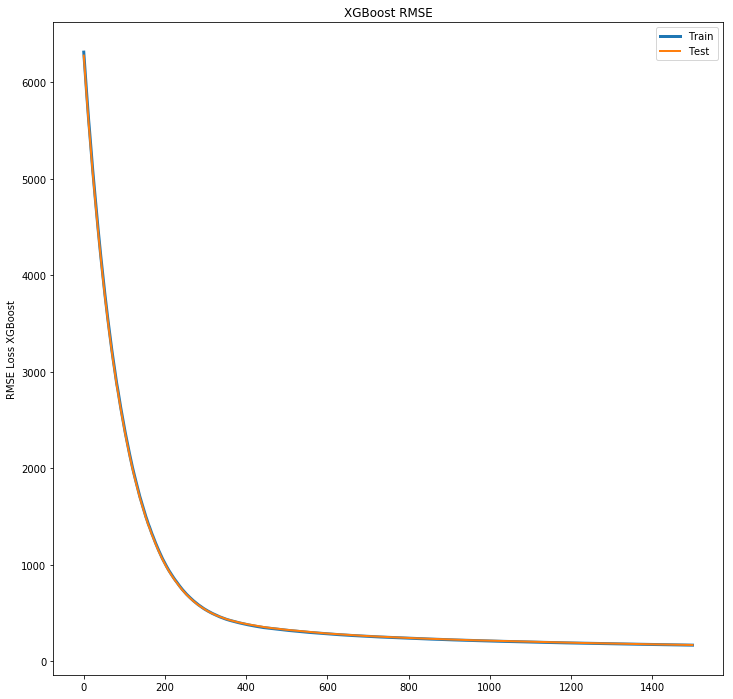

In [0]:
results = xgb.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(figsize=(12,12))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train',linewidth=3)
ax.plot(x_axis, results['validation_1']['rmse'], label='Test',linewidth=2)
ax.legend()

plt.ylabel('RMSE Loss XGBoost')
plt.title('XGBoost RMSE')
plt.show()

In [0]:
pred = xgb.predict(test_2020)
results_df = pd.DataFrame(data={'Original':Data_2020['Volume_of_Traffic'], 'Predicted':pred})
from sklearn.metrics import mean_absolute_error,mean_squared_error
print('MAE for Test Set: ',mean_absolute_error(Data_2020['Volume_of_Traffic'], pred))
print("RMSE for Test Set", np.sqrt(mean_squared_error(Data_2020['Volume_of_Traffic'], pred)))

MAE for Test Set:  328.16515120639593
RMSE for Test Set 723.8912593829199


In [0]:
error_train = pred - Y_train

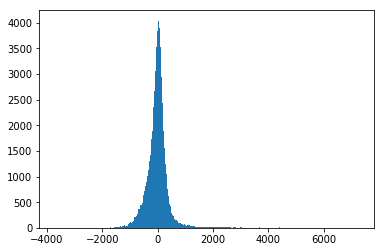

In [0]:
plt.hist(error_train,bins=300);

In [0]:
error_train = np.abs(error_train)

In [0]:
y_upper = pred+(np.mean(error_train)+2*np.std(error_train))
y_lower = pred + (np.mean(error_train)-2*np.std(error_train))
make_zero = lambda x : 0 if x<0 else x
y_lower = np.vectorize(make_zero)(y_lower)

### Plotting the predicition interval for XGBOOST

In [0]:
Data_2020['Prediction'] = pred
Data_2020['Upper Limit'] = y_upper
Data_2020['Lower Limit'] = y_lower

plot_df = Data_2020.groupby('HourSlot')[['Volume_of_Traffic','Prediction', 'Upper Limit', 'Lower Limit']].mean().reset_index()

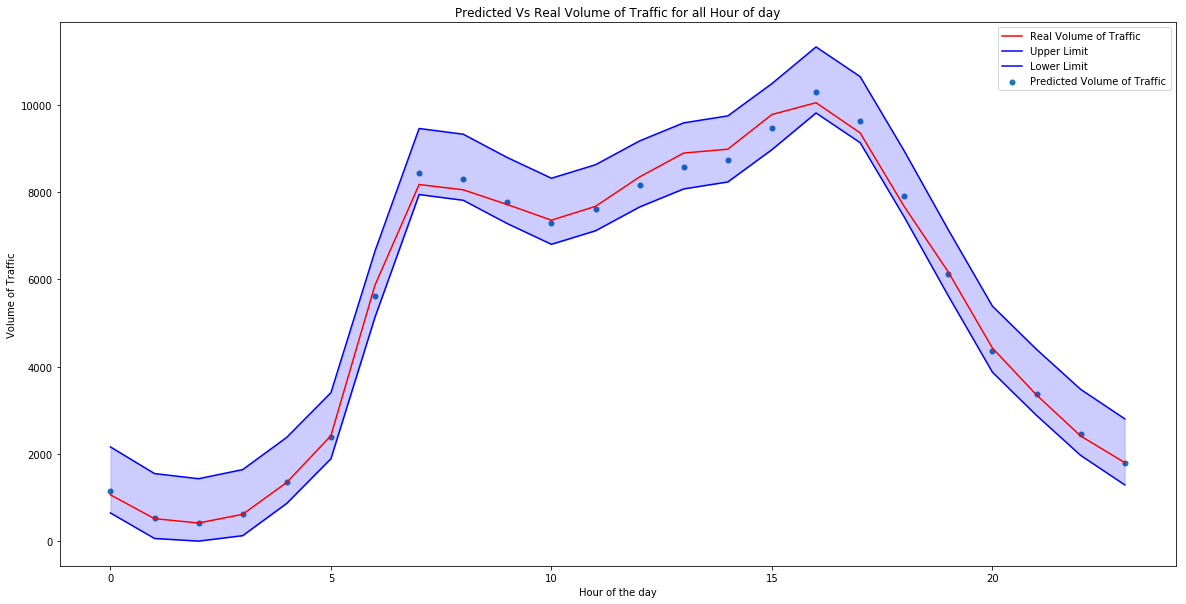

In [0]:
plt.figure(figsize=(20,10))
plt.scatter(plot_df.HourSlot,plot_df['Prediction'], linewidth=0.01,label='Predicted Volume of Traffic') 
plt.plot(plot_df['Volume_of_Traffic'],color='red',label='Real Volume of Traffic')
plt.plot(plot_df['Upper Limit'],color='blue')
plt.plot(plot_df['Lower Limit'],color='blue')

plt.fill_between(plot_df.HourSlot, plot_df['Upper Limit'],  plot_df['Lower Limit'], color='b', alpha=.2)
plt.xlabel('Hour of the day')
plt.ylabel('Volume of Traffic')
plt.title('Predicted Vs Real Volume of Traffic for all Hour of day')
plt.legend()

In [0]:
from sklearn.svm import SVC
algo_SVM = SVC(kernel='linear',cache_size=7000)


In [0]:
algo_SVM.fit(X_train, Y_train)

In [0]:
pred_SVM = algo_SVM.predict(test_2020)
results_df_SVM = pd.DataFrame(data={'Original':Data_2020['Volume_of_Traffic'], 'Predicted':pred_SVM})
print('MAE for Test Set: ',mean_absolute_error(Data_2020['Volume_of_Traffic'], pred))
print("RMSE for Test Set", np.sqrt(mean_squared_error(Data_2020['Volume_of_Traffic'], pred)))

In [0]:
from sklearn.linear_model import LogisticRegression
algo_Logistic = LogisticRegression(solver='liblinear').fit(X_train, Y_train)
pred_logistic = algo_Logistic.predict(test_2020)
results_df_logistic = pd.DataFrame(data={'Original':Data_2020['Volume_of_Traffic'], 'Predicted':pred_logistic})
